In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 11})

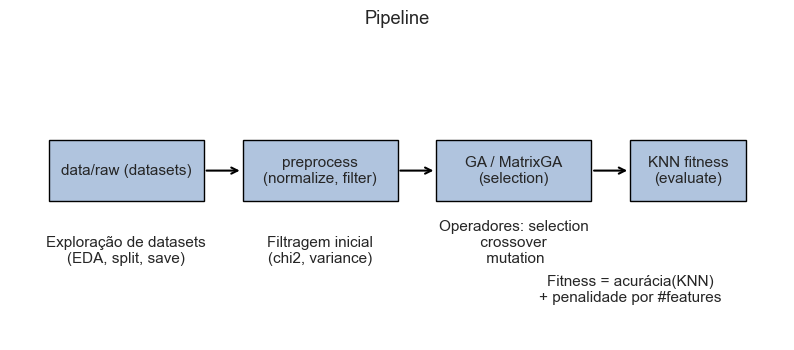

In [5]:
# utilitários de desenho simples
def draw_box(ax, x, y, w, h, text, box_color='lightsteelblue'):
    rect = plt.Rectangle((x, y), w, h, facecolor=box_color, edgecolor='k', linewidth=1.0)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, textwrap.fill(text, 20), ha='center', va='center')

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlim(0, 10)
ax.set_ylim(0, 4)
ax.axis('off')

draw_box(ax, 0.5, 1.8, 2.0, 0.8, 'data/raw\n(datasets)')
draw_box(ax, 3.0, 1.8, 2.0, 0.8, 'preprocess\n(normalize, filter)')
draw_box(ax, 5.5, 1.8, 2.0, 0.8, 'GA / MatrixGA\n(selection)')
draw_box(ax, 8.0, 1.8, 1.5, 0.8, 'KNN fitness\n(evaluate)')

def arrow(ax, x0, y0, x1, y1):
    ax.annotate('', xy=(x1, y1), xytext=(x0, y0), arrowprops=dict(arrowstyle='->', lw=1.5, color='black'))

arrow(ax, 2.5, 2.2, 3.0, 2.2)
arrow(ax, 5.0, 2.2, 5.5, 2.2)
arrow(ax, 7.5, 2.2, 8.0, 2.2)

ax.text(1.5, 1.0, 'Exploração de datasets\n(EDA, split, save)', ha='center')
ax.text(4.0, 1.0, 'Filtragem inicial\n(chi2, variance)', ha='center')
ax.text(6.5, 1.0, 'Operadores: selection\n crossover \n mutation', ha='center')
ax.text(8.0, 0.5, 'Fitness = acurácia(KNN)\n+ penalidade por #features', ha='center')

plt.title('Pipeline')
plt.show()

## 2) Fluxo interno do GA 
Mostramos um diagrama simples do laço de vida de uma geração com contagem de avaliações.

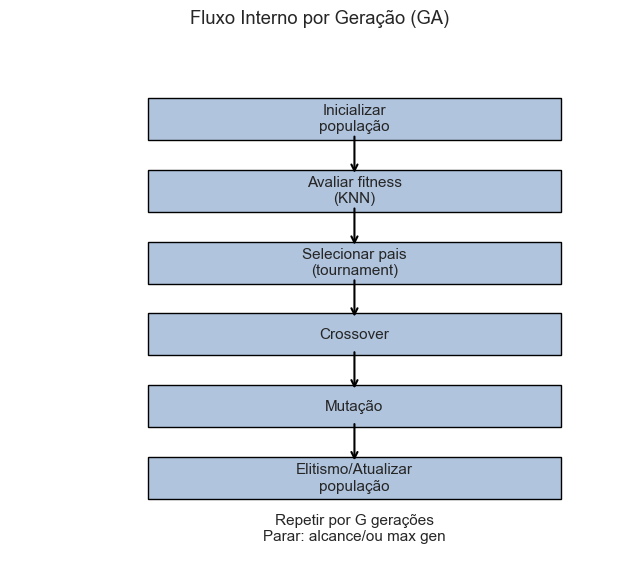

In [6]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_xlim(0, 9)
ax.set_ylim(0, 9)
ax.axis('off')

steps = ['Inicializar população', 'Avaliar fitness (KNN)', 'Selecionar pais (tournament)',
'Crossover', 'Mutação', 'Elitismo/Atualizar população']

y = 8
for s in steps:
    draw_box(ax, 2, y-0.8, 6, 0.7, s)
    y -= 1.2

for i in range(len(steps)-1):
    arrow(ax, 5, 7.3 - i*1.2, 5, 6.6 - i*1.2)

ax.text(5, 0.5, 'Repetir por G gerações\nParar: alcance/ou max gen', ha='center')
plt.title('Fluxo Interno por Geração (GA)')
plt.show()

## 3) Custo de avaliação de fitness — gargalo
Cada avaliação executa um KNN com subset de features. Se N_avaliações = pop_size * generations,
então N_calls × custo(KNN) é o tempo total. Visualizamos o custo relativo e mostramos uma estratégia de paralelização.

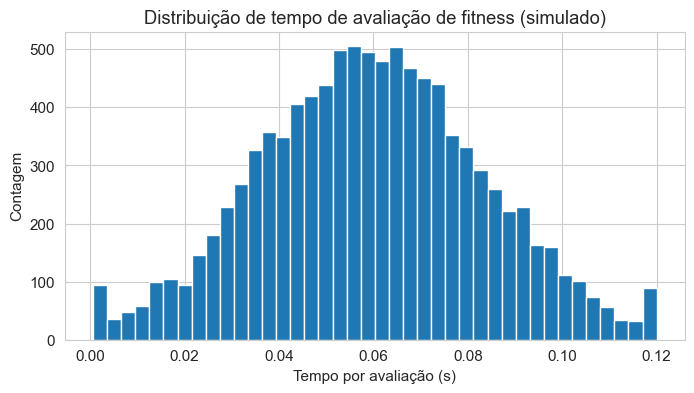

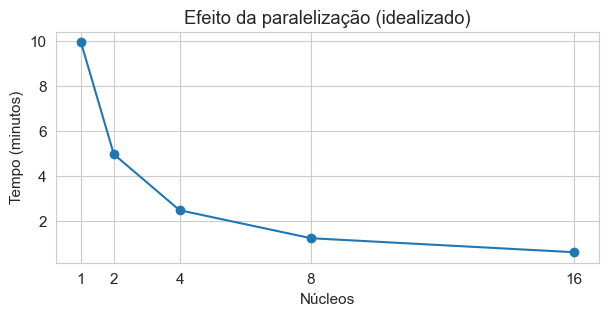

In [4]:
pop_size = 200
generations = 50
calls = pop_size * generations
calls

# suponha tempos (segundos) por avaliação dependendo do n_features selecionadas
selected_features = np.clip(np.random.normal(100, 40, size=calls).astype(int), 1, 200)
knn_time_per_feature = 0.0006 # hipotético: 0.6 ms por feature para avaliar
times = selected_features * knn_time_per_feature

# plot histograma de tempos
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(times, bins=40)
ax.set_xlabel('Tempo por avaliação (s)')
ax.set_ylabel('Contagem')
ax.set_title('Distribuição de tempo de avaliação de fitness (simulado)')
plt.show()

# custo total simulado e efeito da paralelização
total_time = times.sum()
n_cores = np.array([1,2,4,8,16])
parallel_time = total_time / n_cores

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(n_cores, parallel_time/60, marker='o')
ax.set_xlabel('Núcleos')
ax.set_ylabel('Tempo (minutos)')
ax.set_title('Efeito da paralelização (idealizado)')
ax.set_xticks(n_cores)
plt.grid(True)
plt.show()